# Eval on Val

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
from PIL import Image

import os
import csv
import numpy as np
import glob

from sklearn.metrics import accuracy_score, f1_score

In [75]:
import csv
from tqdm import tqdm

label_dict = {}
with open("../ComParE2017_Cold_4students/lab/ComParE2017_Cold.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    rows = list(reader)
    for row in tqdm(rows, desc="Loading labels"):
        label_dict[row["file_name"]] = row["Cold (upper respiratory tract infection)"]

Loading labels: 100%|██████████| 19101/19101 [00:00<00:00, 2387798.07it/s]


In [76]:
import os
def search_in_labels(filename, label_dict):
    base_name = os.path.splitext(filename)[0]
    
    if "_logmel" in base_name:
        base_name = base_name.replace("_logmel", "")
    if "_flipped" in base_name:
        base_name = base_name.replace("_flipped", "")
    
    parts = base_name.split("_")
    if len(parts) >= 2:
        audio_filename = f"{parts[0]}_{parts[1]}.wav"
    else:
        audio_filename = f"{base_name}.wav"
    
    return label_dict.get(audio_filename, None)

In [77]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import torch
import torch.nn.functional as F

class SpectrogramDataset(Dataset):
    def __init__(self, image_paths, label_dict, transform=None, window_size=128, stride=64, is_training=False, num_windows=3):
        self.image_paths = image_paths
        self.label_dict = label_dict
        self.is_training = is_training 
        self.window_size = window_size
        self.stride = stride
        self.num_windows = num_windows  # 新增参数

        self.base_transform = transforms.Compose([
            # transforms.RandomAffine(degrees=0, translate=(0.3, 0)),
            transforms.ToTensor()
        ])
        
        self.c_train_transform = transforms.Compose([
            transforms.RandomAffine(degrees=0, translate=(0.3, 0)),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        filename = os.path.basename(image_path)
        label = search_in_labels(filename, self.label_dict)
        label_num = 1 if label == "C" else 0

        image = Image.open(image_path).convert("RGB")

        if self.is_training and label == "C":
            image = self.c_train_transform(image)
        elif self.is_training and label == "NC":
            image = self.base_transform(image)
        else:
            image = transforms.ToTensor()(image)

        _, H, W = image.shape
        assert H == 128, f"Image height must be 128, but got {H}"

        windows = []
        for start in range(0, W - self.window_size + 1, self.stride):
            window = image[:, :, start:start + self.window_size]
            windows.append(window)

        if (W - self.window_size) % self.stride != 0:
            last_window = image[:, :, -self.window_size:]
            windows.append(last_window)

        if len(windows) == 0:
            pad_width = self.window_size - W
            image_padded = F.pad(image, (0, pad_width), mode='constant', value=0)
            window = image_padded[:, :, :self.window_size]
            windows.append(window)

        windows = torch.stack(windows)  # Shape: (num_extracted_windows, 3, 128, 128)

        if self.is_training:
            # 随机选择指定数量的windows
            num_available = windows.shape[0]
            
            if num_available >= self.num_windows:
                rand_indices = torch.randperm(num_available)[:self.num_windows]
                selected_windows = windows[rand_indices]  
            else:
                rand_indices = torch.randint(0, num_available, (self.num_windows,))
                selected_windows = windows[rand_indices]  
            
            labels = torch.full((self.num_windows,), label_num, dtype=torch.long)
            
            return selected_windows, labels
        else:
            return windows, label_num

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNNBinaryClassifier(nn.Module):
    def __init__(self, input_shape=(3, 224, 224), num_classes=1):
        super(ImprovedCNNBinaryClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(input_shape[0], 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  
        
        self.fc1 = nn.Linear(512 * 4 * 4, 512)  
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        
        x = self.adaptive_pool(x) 
        
        x = x.view(x.size(0), -1)  # [batch, 512*4*4]
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load weights from the pretrained model
model = ImprovedCNNBinaryClassifier().to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3).to(device))  
pretrained_model_path = "../model/best_sliding_window.pth"
checkpoint = torch.load(pretrained_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model

ImprovedCNNBinaryClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (adaptive_pool): AdaptiveAvgPool2d(outpu

In [81]:
import glob
# Create a dataset and dataloader for evaluation
data_split = ["train_files", "devel_files"]
img_dir = "../spectrograms_variable_width"

def collect_image_paths(split_name):
        sub_dir = os.path.join(img_dir, split_name)
        print(f"🔍 Looking for images in: {sub_dir}")
        
        if not os.path.exists(sub_dir):
            print(f"❌ Directory does not exist: {sub_dir}")
            return []
        
        png_files = glob.glob(os.path.join(sub_dir, "*.png"))
        
        # Filter out files with "flipped" in their names
        filtered_files = [f for f in png_files if "flipped" not in os.path.basename(f)]
        
        print(f"📁 Found {len(png_files)} PNG files in {split_name}")
        print(f"📋 After filtering out 'flipped' files: {len(filtered_files)} files")
        
        return filtered_files
    

print("🚀 Collecting image paths...")
train_image_paths = collect_image_paths("train_files")
devel_image_paths = collect_image_paths("devel_files")

devel_dataset = SpectrogramDataset(devel_image_paths, label_dict)
devel_loader = DataLoader(devel_dataset, batch_size=1, shuffle=False)

🚀 Collecting image paths...
🔍 Looking for images in: ../spectrograms_variable_width\train_files
📁 Found 10475 PNG files in train_files
📋 After filtering out 'flipped' files: 9505 files
🔍 Looking for images in: ../spectrograms_variable_width\devel_files
📁 Found 10607 PNG files in devel_files
📋 After filtering out 'flipped' files: 9596 files


In [82]:
from tqdm import trange
from sklearn.metrics import accuracy_score, f1_score

def eval_with_voting(model, dataset, criterion, device, threshold=0.5, vote_mode='soft'):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in trange(len(dataset), desc="Validating"):
            windows, label = dataset[i]  # windows: (N, C, H, W)
            label = torch.tensor(label).to(device)

            windows = windows.to(device)  # shape: (N, C, H, W)
            logits = model(windows).squeeze()  # shape: (N,) or (N,1)

            # 确保 logits 是 1D
            if logits.dim() > 1:
                logits = logits.squeeze()
            if logits.dim() == 0:
                logits = logits.unsqueeze(0)

            probs = torch.sigmoid(logits)

            # 🎯 投票
            if vote_mode == 'soft':
                avg_prob = probs.mean().item()
                final_pred = 1 if avg_prob > threshold else 0
            else:  # 'hard'
                window_preds = (probs > threshold).long()
                final_pred = torch.mode(window_preds).values.item()

            all_preds.append(final_pred)
            all_labels.append(label.item())

            # 平均窗口 loss
            repeated_label = label.repeat(len(logits))
            sample_loss = criterion(logits, repeated_label.float()).item()
            total_loss += sample_loss

    avg_loss = total_loss / len(dataset)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # 🎯 返回 loss, accuracy, f1, predictions, labels
    return avg_loss, acc, f1, all_preds, all_labels

In [87]:
avg_val_loss, val_accuracy, val_f1, val_preds, val_labels = eval_with_voting(
        model=model,
        dataset=devel_dataset,
        criterion=criterion,
        device=device,
        threshold=0.4,
        vote_mode='soft'
    )

Validating: 100%|██████████| 9596/9596 [00:48<00:00, 197.92it/s]


In [88]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score

uar = recall_score(val_labels, val_preds, average='macro')

print(f"\n📈 PERFORMANCE METRICS:")
print(f"   UAR (Unweighted Average Recall): {uar:.4f}")

if len(set(val_labels)) > 1 and len(set(val_preds)) > 1:
    cm = confusion_matrix(val_labels, val_preds)
    
    class_recalls = []
    for i in range(len(cm)):
        if cm[i].sum() > 0:  
            recall = cm[i, i] / cm[i].sum()
            class_recalls.append(recall)
        else:
            class_recalls.append(0.0)
    
    print(f"\n🎯 PER-CLASS RECALL:")
    class_names = ['Healthy', 'Cold']
    for i, (name, recall) in enumerate(zip(class_names, class_recalls)):
        print(f"   Class {i} ({name}): {recall:.4f}")


📈 PERFORMANCE METRICS:
   UAR (Unweighted Average Recall): 0.6144

🎯 PER-CLASS RECALL:
   Class 0 (Healthy): 0.8222
   Class 1 (Cold): 0.4065


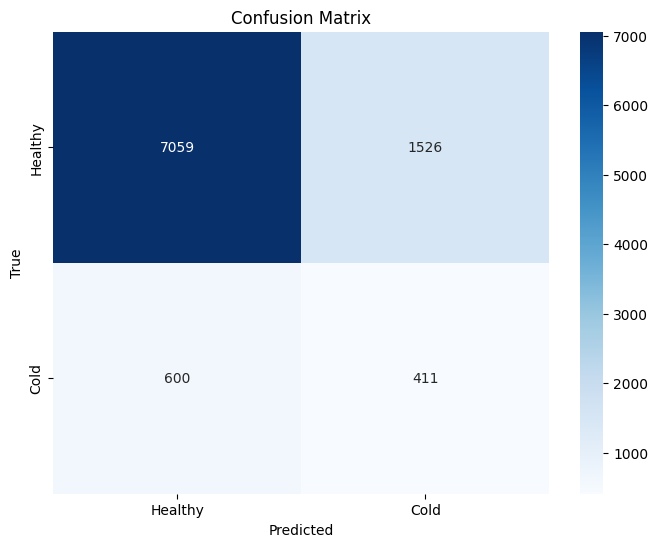

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, class_names=['Healthy', 'Cold'])

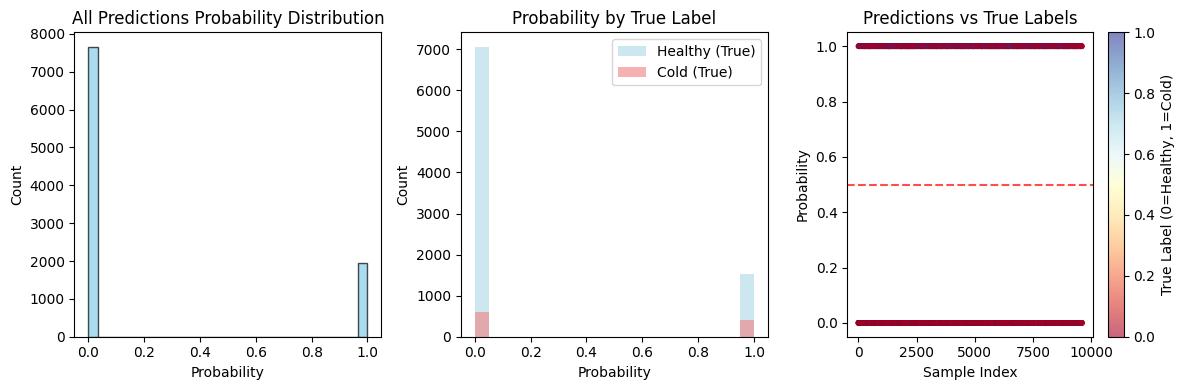

In [90]:
import numpy as np
val_probs = np.array(val_preds)
val_labels = np.array(val_labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(val_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('All Predictions Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')

healthy_probs = val_probs[val_labels == 0]
cold_probs    = val_probs[val_labels == 1]

plt.subplot(1, 3, 2)
plt.hist(healthy_probs, bins=20, alpha=0.6, label='Healthy (True)', color='lightblue')
plt.hist(cold_probs,    bins=20, alpha=0.6, label='Cold (True)',    color='lightcoral')
plt.title('Probability by True Label')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(val_probs)), val_probs, c=val_labels, 
            cmap='RdYlBu', alpha=0.6, s=10)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
plt.title('Predictions vs True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.colorbar(label='True Label (0=Healthy, 1=Cold)')

plt.tight_layout()
plt.show()